The purpose of this notebook is to calculate CF% through a certain number of games, and for the rest of the season's games.

In [1]:
import pandas as pd
from pylab import *
%matplotlib inline
from pyarrow import ArrowIOError

from scrapenhl2.scrape import teams, team_info, schedules
from scrapenhl2.manipulate import manipulate as manip

In [2]:
generate = False
fname = '/Users/muneebalam/Desktop/team_game_data.csv'

if generate:
    team_dfs = []
    for season in range(2010, 2018):
        for team in schedules.get_teams_in_season(season):

            # Read in the PBP and get CF and CA counts by game, regular season only
            try:
                df = teams.get_team_pbp(season, team).query('Game < 30001')
            except ArrowIOError:
                continue
            df = manip.filter_for_five_on_five(manip.filter_for_corsi(df))
            df.loc[:, 'CFCA'] = df.Team.apply(lambda x: 'CF' if x == team_info.team_as_id(team) else 'CA')
            grouped = df[['Game', 'CFCA']].assign(Count=1).groupby(['Game', 'CFCA'], as_index=False).count()
            grouped = grouped.sort_values('Game') \
                .pivot_table(index='Game', columns='CFCA', values='Count')

            # Add in game number
            grouped.loc[:, 'GameNum'] = 1
            grouped.loc[:, 'GameNum'] = grouped.GameNum.cumsum()

            # Calculate cumulative sums
            grouped.loc[:, 'YTD_CF'] = grouped['CF'].cumsum()
            grouped.loc[:, 'YTD_CA'] = grouped['CA'].cumsum()
            grouped.loc[:, 'YTD_CF%'] = grouped['YTD_CF'] / (grouped['YTD_CF'] + grouped['YTD_CA'])

            # Get EOY numbers and subtract
            totals = grouped.max()

            grouped.loc[:, 'ROY_CF'] = totals['YTD_CF'] - grouped['YTD_CF']
            grouped.loc[:, 'ROY_CA'] = totals['YTD_CA'] - grouped['YTD_CA']
            grouped.loc[:, 'ROY_CF%'] = grouped['ROY_CF'] / (grouped['ROY_CF'] + grouped['ROY_CA'])

            team_dfs.append(grouped[['GameNum', 'YTD_CF%', 'ROY_CF%']].assign(Season=season, 
                                                                              Team=team_info.team_as_str(team)))
        print('Done with', season)
    data = pd.concat(team_dfs)
    data.to_csv(fname, index=False)
data = pd.read_csv(fname)
data.head()

,GameNum,YTD_CF%,ROY_CF%,Season,Team
0,1,0.487179,0.522637,2010,NJD
1,2,0.475000,0.523451,2010,NJD
2,3,0.477679,0.523874,2010,NJD
3,4,0.482650,0.524342,2010,NJD
4,5,0.501305,0.523578,2010,NJD


Now we make some plots and calculate some figures. For example, here's how the correlation (Pearson's r) changes by game number:

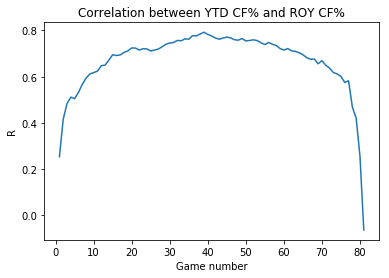

In [3]:
# Drop short season and current season, and get correlations
data2 = data[(data.Season != 2012) & (data.Season != 2017)].dropna()
corrs = data2.drop({'Season', 'Team'}, axis=1).groupby('GameNum').corr().drop('ROY_CF%', axis=1)
corrs = corrs[corrs['YTD_CF%'] < 1]
corrs = corrs.reset_index().drop('level_1', axis=1).rename(columns={'YTD_CF%': 'r'})
plot(corrs.GameNum, corrs.r)
xlabel('Game number')
ylabel('R')
title('Correlation between YTD CF% and ROY CF%')

Here's how the slope changes by game:

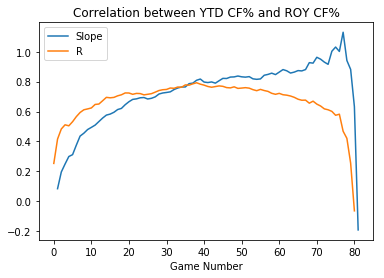

In [4]:
# Now look at the slope
from scipy.stats import linregress
def get_slope(df):
    m, b, r, p, e = linregress(df['YTD_CF%'], df['ROY_CF%'])
    return m
plot(data2.groupby('GameNum').apply(get_slope), label = 'Slope')
xlabel('Game Number')

plot(corrs.r, label = 'R')
title('Correlation between YTD CF% and ROY CF%')
legend(loc=2)

You'll note that although the predictivity (as measured by r) is best at 40 games, the slope is still not 1--meaning we expect some regression still.

You can see that in the scatterplot below (with the best-fit and 1:1 lines included for reference):

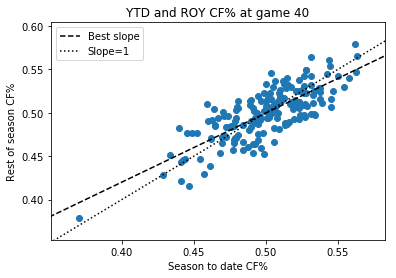

In [5]:
tmp = data2[data2.GameNum == 40]
x = 'YTD_CF%'
y = 'ROY_CF%'

scatter(tmp[x], tmp[y], label='_nolegend')
xlabel('Season to date CF%')
ylabel('Rest of season CF%')
title('YTD and ROY CF% at game 40')

m, b, r, p, e = linregress(tmp[x], tmp[y])
xs = arange(0, 1, 0.01)
ys = m * xs + b
xlimits = xlim()
ylimits = ylim()

plot(xs, ys, color='k', ls='--', label='Best slope')
plot(xs, xs, color='k', ls=':', label='Slope=1')
xlim(*xlimits)
ylim(*ylimits)
legend(loc=2)